In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv


In [2]:
#  Import and read the data 
train = pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv')
test=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv')
subm=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv')


In [3]:
#Drop the non-beneficial ID columns and assign ID column as labels
def set_index (df):
    df.set_index('id', inplace=True)
    return df

train_df=set_index(train)
test_df=set_index(test)

# Data Exploration

In [4]:
# Checking the datatypes for train dataset
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [5]:
test_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
dtype: object

In [6]:
#Determine the number of unique values in each column
def dataset_unique_counts(df):
    unique_counts = df.nunique()
    print(unique_counts)

In [7]:
#Unique values for train dataset
dataset_unique_counts(train_df)

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64


In [8]:
#Unique values for test dataset
dataset_unique_counts(test_df)

brand             53
model           1791
model_year        34
milage          2973
fuel_type          7
engine          1038
transmission      44
ext_col          230
int_col          111
accident           2
clean_title        1
dtype: int64


In [9]:
def price_plot(df):
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=df, y='price', jitter=True, color='purple', alpha=0.5)
    plt.title('Strip Plot: Price Distribution')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


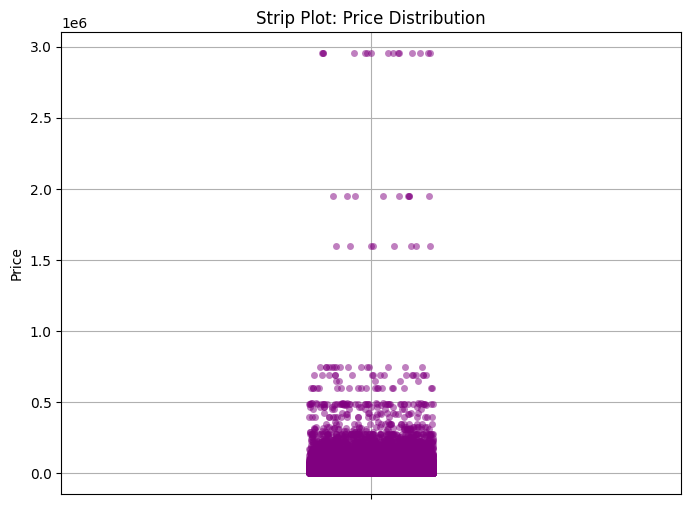

In [10]:
price_plot(train_df)

Above Histogram shows that most cars lie in the lower range of price.
The above graph has outliers from 0.4 onwards, which need to be removed.

In [11]:
#Train data needs to be cleaned from outliers
train_df['price'].describe()


count    5.427300e+04
mean     3.921844e+04
std      7.282634e+04
min      2.000000e+03
25%      1.550000e+04
50%      2.800000e+04
75%      4.500000e+04
max      2.954083e+06
Name: price, dtype: float64

In [12]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

29500.0


In [13]:
#use IQR value to filter out the outliers
outliersfree_df = train_df[~((train_df['price'] < (Q1 - 1.5 * IQR)) |(train_df['price'] > (Q3 + 0.7 * IQR)))]
outliersfree_df.shape

(47678, 12)

In [14]:
outliersfree_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850
...,...,...,...,...,...,...,...,...,...,...,...,...
54267,Land,Rover Range Rover Sport HST MHEV,2020,69000,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Silver,Black,None reported,Yes,32500
54268,BMW,X6 xDrive50i,2017,29000,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Brown,None reported,Yes,29000
54269,Audi,A4 2.0T Premium,2015,94634,E85 Flex Fuel,220.0HP 2.0L 4 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,6500


The above plot looks more homogeneous than the previous one after removal of outliers.

# **Data wrangling**

I will reduce the number of features in string data categories, and will remain the numeric categories as they are.

In [15]:
#Determine the number of unique values in each column.
dataset_unique_counts(outliersfree_df)

brand             51
model           1795
model_year        34
milage          3093
fuel_type          7
engine          1045
transmission      43
ext_col          245
int_col          118
accident           2
clean_title        1
price           1108
dtype: int64


In [16]:
#Determine the number of unique values in each column.
dataset_unique_counts(test_df)

brand             53
model           1791
model_year        34
milage          2973
fuel_type          7
engine          1038
transmission      44
ext_col          230
int_col          111
accident           2
clean_title        1
dtype: int64


***Model cleaning***

In [17]:
# Value counts function 
def feature_value_counts(df, column_name):
    value_counts = df[column_name].value_counts()
    return value_counts

Brand feature

In [18]:
brand_counts_train = feature_value_counts(outliersfree_df, 'brand')
brand_counts_test = feature_value_counts(test_df, 'brand')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
brand_types_to_replace = brand_counts_train[brand_counts_train < cutoff_value].index

# Replace models in the training dataframe
for brand_c in brand_types_to_replace:
    outliersfree_df.loc[outliersfree_df['brand'] == brand_c, 'brand'] = "Other"

# Apply the same replacements to the test dataframe
test_df.loc[test_df['brand'].isin(brand_types_to_replace), 'brand'] = "Other"
test_df.loc[~test_df['brand'].isin(outliersfree_df['brand'].unique()), 'brand'] = "Other"

# Check the updated value counts
brand_counts_train_updated = outliersfree_df['brand'].value_counts()
brand_counts_test_updated = test_df['brand'].value_counts()


In [19]:
len(brand_counts_train_updated)

27

In [20]:
len(brand_counts_test_updated)

27

*Model feature*

In [21]:
model_counts_train = feature_value_counts(outliersfree_df, 'model')
model_counts_test = feature_value_counts(test_df, 'model')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
model_types_to_replace = model_counts_train[model_counts_train < cutoff_value].index

# Replace models in the training dataframe
for model_c in model_types_to_replace:
    outliersfree_df.loc[outliersfree_df['model'] == model_c, 'model'] = "Other"

# Apply the same replacements to the test dataframe
test_df.loc[test_df['model'].isin(model_types_to_replace), 'model'] = "Other"
test_df.loc[~test_df['model'].isin(outliersfree_df['model'].unique()), 'model'] = "Other"

# Check the updated value counts
model_counts_train_updated = outliersfree_df['model'].value_counts()
model_counts_test_updated = test_df['model'].value_counts()


In [22]:
len(model_counts_train_updated)

6

In [23]:
len(model_counts_test_updated)

6

*Fuel feature*

In [24]:
# Replace '–' with 'Other' in the 'fuel_type' column
def cleaning_not_supported_and_dashes(df):
    # Replace unsupported dashes with 'Other'
    df.loc[df['fuel_type'] == '–', 'fuel_type'] = 'Other'
    # Remove rows where 'fuel_type' is 'not supported'
    cleaned_df = df[df['fuel_type'] != 'not supported']
    # Calculate and return the value counts of the cleaned 'fuel_type' column
    fuel_counts = cleaned_df['fuel_type'].value_counts()
    return cleaned_df

In [25]:
cleaned_train=cleaning_not_supported_and_dashes(train_df)
feature_value_counts(cleaned_train, 'fuel_type')


fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
Other               294
Plug-In Hybrid      182
Name: count, dtype: int64

In [26]:
cleaned_test=cleaning_not_supported_and_dashes(test_df)
feature_value_counts(cleaned_test, 'fuel_type')


fuel_type
Gasoline          33033
Hybrid             1112
E85 Flex Fuel      1018
Diesel              671
Other               197
Plug-In Hybrid      148
Name: count, dtype: int64

*Engine feature*

In [27]:
#Reducing the features unique values
engine_counts_train = feature_value_counts(cleaned_train, 'engine')
engine_counts_test = feature_value_counts(cleaned_test, 'engine')

cutoff_value = 400 # Keep if database has 451 and more records of this car model
engine_types_to_replace = engine_counts_train[engine_counts_train < cutoff_value].index

# Replace models in the training dataframe
for engine_c in engine_types_to_replace:
    cleaned_train.loc[cleaned_train['engine'] == engine_c, 'engine'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['engine'].isin(engine_types_to_replace), 'engine'] = "Other"
cleaned_test.loc[~cleaned_test['engine'].isin(cleaned_train['engine'].unique()), 'engine'] = "Other"

# Check the updated value counts
engine_counts_train_updated = cleaned_train['engine'].value_counts()
engine_counts_test_updated = cleaned_test['engine'].value_counts()


In [28]:
len(engine_counts_train_updated)

20

In [29]:
len(engine_counts_test_updated)

20

*Transmission feature*

In [30]:
#Reducing the features unique values
trans_counts_train = feature_value_counts(cleaned_train, 'transmission')
trans_counts_test = feature_value_counts(cleaned_test, 'transmission')

cutoff_value = 100 # Keep if database has 451 and more records of this car model
trans_types_to_replace = trans_counts_train[trans_counts_train < cutoff_value].index

# Replace models in the training dataframe
for trans_c in trans_types_to_replace:
    cleaned_train.loc[cleaned_train['transmission'] == trans_c, 'transmission'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['transmission'].isin(trans_types_to_replace), 'transmission'] = "Other"
cleaned_test.loc[~cleaned_test['transmission'].isin(cleaned_train['transmission'].unique()), 'transmission'] = "Other"

# Check the updated value counts
trans_counts_train_updated = cleaned_train['transmission'].value_counts()
trans_counts_test_updated = cleaned_test['transmission'].value_counts()


In [31]:
trans_counts_train_updated

transmission
A/T                                  16754
8-Speed A/T                           7287
Transmission w/Dual Shift Mode        6453
6-Speed A/T                           5944
6-Speed M/T                           3618
7-Speed A/T                           3415
10-Speed A/T                          2187
8-Speed Automatic                     1189
5-Speed A/T                           1185
9-Speed A/T                           1073
4-Speed A/T                            764
5-Speed M/T                            718
CVT Transmission                       692
10-Speed Automatic                     642
6-Speed Automatic                      516
Other                                  474
Automatic                              441
M/T                                    359
9-Speed Automatic                      344
7-Speed Automatic with Auto-Shift      110
7-Speed M/T                            104
Name: count, dtype: int64

In [32]:
trans_counts_test_updated

transmission
A/T                                  11269
8-Speed A/T                           4818
Transmission w/Dual Shift Mode        4266
6-Speed A/T                           3901
6-Speed M/T                           2482
7-Speed A/T                           2216
10-Speed A/T                          1443
5-Speed A/T                            847
8-Speed Automatic                      739
9-Speed A/T                            688
4-Speed A/T                            551
CVT Transmission                       485
5-Speed M/T                            471
10-Speed Automatic                     406
Other                                  329
6-Speed Automatic                      320
Automatic                              287
M/T                                    273
9-Speed Automatic                      230
7-Speed Automatic with Auto-Shift       86
7-Speed M/T                             72
Name: count, dtype: int64

**External colour feature**

In [33]:
#Determine the number of unique values in each column.
trans_counts_train = feature_value_counts(cleaned_train, 'ext_col')
trans_counts_train

ext_col
Black                      15078
White                      13422
Gray                        7908
Silver                      5158
Blue                        4668
                           ...  
Balloon White                  1
Firenze Red Metallic           1
Orca Black Metallic            1
Radiant Red Metallic II        1
Magnetic Gray Clearcoat        1
Name: count, Length: 260, dtype: int64

In [34]:
trans_counts_test = feature_value_counts(cleaned_test, 'ext_col')
trans_counts_test

ext_col
Black                      10027
White                       8793
Gray                        5383
Silver                      3465
Blue                        3154
                           ...  
Crystal White Pearl            1
Blue Metallic                  1
Magnetic Gray Clearcoat        1
Pure White                     1
Sparkling Silver               1
Name: count, Length: 230, dtype: int64

In [35]:
#Reducing the features unique values
ext_col_counts_train = feature_value_counts(cleaned_train, 'ext_col')
ext_col_counts_test = feature_value_counts(cleaned_test, 'ext_col')

cutoff_value = 1000 # Keep if database has 451 and more records of this car model
ext_col_types_to_replace =ext_col_counts_train[ext_col_counts_train < cutoff_value].index

# Replace models in the training dataframe
for ext_col_c in ext_col_types_to_replace:
    cleaned_train.loc[cleaned_train['ext_col'] == ext_col_c, 'ext_col'] = "Other"

# Apply the same replacements to the test dataframe
cleaned_test.loc[cleaned_test['ext_col'].isin(ext_col_types_to_replace), 'ext_col'] = "Other"
cleaned_test.loc[~cleaned_test['ext_col'].isin(cleaned_train['ext_col'].unique()), 'ext_col'] = "Other"

# Check the updated value counts
ext_col_counts_train_updated = cleaned_train['ext_col'].value_counts()
ext_col_counts_test_updated = cleaned_test['ext_col'].value_counts()

In [36]:
ext_col_counts_train_updated

ext_col
Black     15078
White     13422
Gray       7908
Silver     5158
Other      5022
Blue       4668
Red        3013
Name: count, dtype: int64

In [37]:
ext_col_counts_test_updated

ext_col
Black     10027
White      8793
Gray       5383
Silver     3465
Other      3290
Blue       3154
Red        2067
Name: count, dtype: int64

*Internal colour feature*

In [38]:
# Look at colours value counts for binning
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts.head(50)

int_col
Black                    31818
Beige                     7995
Gray                      6250
Brown                     2239
Red                       1499
White                     1172
–                         1045
Jet Black                  365
Orange                     248
Ebony                      237
Blue                       212
Silver                     129
Gold                        95
Global Black                58
Green                       56
Medium Stone                39
Black Onyx                  34
Charcoal                    32
Nero Ade                    32
Diesel Gray / Black         30
Rioja Red                   28
Medium Dark Slate           25
Portland                    22
Graphite                    22
White / Brown               22
Medium Earth Gray           21
Tan                         19
Hotspur                     17
Adrenaline Red              17
Light Slate                 17
Shara Beige                 16
Canberra Beige              16


In [39]:
cleaned_train.loc[cleaned_train['int_col'] == '–', 'int_col'] = 'Other'

In [40]:
cutoff_value = 10
int_col_types_to_replace = int_col_counts[int_col_counts < cutoff_value].index

# Replace in the dataframe
for int_col_c in int_col_types_to_replace:
    cleaned_train.loc[cleaned_train['int_col'] == int_col_c, 'int_col'] = "Other"

# Check the updated value counts
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts

int_col
Black                    31818
Beige                     7995
Gray                      6250
Brown                     2239
Red                       1499
Other                     1355
White                     1172
Jet Black                  365
Orange                     248
Ebony                      237
Blue                       212
Silver                     129
Gold                        95
Global Black                58
Green                       56
Medium Stone                39
Black Onyx                  34
Charcoal                    32
Nero Ade                    32
Diesel Gray / Black         30
Rioja Red                   28
Medium Dark Slate           25
White / Brown               22
Portland                    22
Graphite                    22
Medium Earth Gray           21
Tan                         19
Light Slate                 17
Hotspur                     17
Adrenaline Red              17
Shara Beige                 16
Canberra Beige              16


In [41]:
# Determine the cleaned number of unique values in each column.
unique_counts = cleaned_train.nunique()
unique_counts

brand             53
model           1825
model_year        34
milage          3212
fuel_type          6
engine            20
transmission      21
ext_col            7
int_col           43
accident           2
clean_title        1
price           1481
dtype: int64

In [42]:
#The last column "Clean_title" is the same "Yes" answer for all rows, that gives no value to analysis. 
#Drop this column.
final_train=cleaned_train.drop(columns=['clean_title'])


In [43]:
# Display the value counts for each column
for column in final_train.columns:
    value_counts = final_train[column].value_counts()
    print(value_counts)


brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2312
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1251
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             27
Merc

***Liner Regression***

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(final_train)
X.shape


(54269, 1980)

In [46]:
# Split our preprocessed data into our features and target arrays
y=X['price'].values.reshape(-1, 1)

In [47]:
#Removing the price from the prediction features
X = X.drop(['price'], axis=1)


In [48]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [49]:
#make predictions
yhat = lm.predict(X)
yhat[0:5]

array([[49805.21945022],
       [16857.40666137],
       [11349.84041899],
       [78801.09033702],
       [ 8664.35151379]])

In [50]:
#find the intercept
lm.intercept_

array([-2606165.95101663])

In [51]:
#find the slope
lm.coef_

array([[ 1.32986835e+03, -1.54226996e-01,  1.91852065e+04, ...,
        -1.54709338e+04, -1.61662180e+03,  1.61662180e+03]])

In [52]:
#find the MSE
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y, yhat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 4364944726.147619


In [53]:
#find the RMSE
rmse = np.sqrt(mse)
rmse

66067.72832592035

In [54]:
#find rscore
from sklearn.metrics import r2_score
r2_score(y, yhat)

0.17703361085565938

# Validation with test data